In [ ]:
pip install -q git+https://github.com/cpgoodri/jax_transformations3d.git

In [104]:
%load_ext autoreload
%autoreload 2

import jax
from jax import jit, vmap
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax_transformations3d as jts
import colorsys
import numpy as np
import math
from tqdm.auto import tqdm, trange

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
@partial(vmap, in_axes=(None, None, 0, 0), out_axes=-1)
def ray_dist_to_intersect(ray_origin, ray_dir, sphere_center, sphere_radius):
    # ray_dir should be normalized
    offset_ray_origin = ray_origin-sphere_center
    a = jnp.dot(ray_dir, ray_dir)
    b = 2*jnp.dot(offset_ray_origin, ray_dir)
    c = jnp.dot(offset_ray_origin, offset_ray_origin) - sphere_radius**2

    discriminant = b**2 - 4*a*c

    dist = (-b - jnp.sqrt(discriminant)) / (2*a)

    # sphere was hit if (discriminant >= 0) & (dist >= 0)
    # if discriminant < 0, then dist is nan already, if dist < 0, then set dist to nan
    dist = jnp.where(dist < 0, jnp.nan, dist)

    return dist

def ray_trace_batch_spheres(ray_origin, ray_dir, sphere_center, sphere_radius):
    dist = ray_dist_to_intersect(ray_origin, ray_dir, sphere_center, sphere_radius)
    closest_hit = jnp.nanargmin(dist)
    dist = dist[closest_hit]

    return dist, closest_hit

@jit
@partial(vmap, in_axes=(1, 1, 1, None, None, None, None, None, None))
@partial(vmap, in_axes=(0, 0, 0, None, None, None, None, None, None))
def ray_trace(ray_origin, ray_dir, key, sphere_center, sphere_radius, mat_color, em_color, em_strength, mat):
    inc_light = jnp.zeros((3,))
    ray_color = jnp.ones((3,))
    #done = 0

    for i in range(8):
        dist, closest_hit = ray_trace_batch_spheres(ray_origin, ray_dir, sphere_center, sphere_radius)

        did_hit = ~jnp.isnan(dist) # or: closest_hit != -1

        #done = done | (did_hit & (em_strength[closest_hit] == 1) & (jnp.arange(10)[i] == 0))
        #did_hit = did_hit & ~done

        hit_point = ray_origin + ray_dir*dist
        normal = hit_point - sphere_center[closest_hit]
        normal = normal / jnp.linalg.norm(normal)

        emitted_light = em_color[closest_hit]*em_strength[closest_hit]
        light_strength = jnp.dot(normal, -ray_dir)
        light_strength = jnp.where(jnp.isnan(light_strength), 0, light_strength)
        inc_light += did_hit*(emitted_light * ray_color)
        # *light_strength
        ray_color = did_hit*ray_color*mat_color[closest_hit] + (~did_hit)*ray_color 
        
        key, subkey = jax.random.split(key, 2)
        random_dir = jax.random.normal(subkey, (3,))
        random_dir = random_dir / jnp.linalg.norm(random_dir)
        diffuse_reflect = random_dir*jnp.sign(jnp.dot(random_dir, normal))
        diffuse_reflect = diffuse_reflect / jnp.linalg.norm(diffuse_reflect)

        specular_reflect = ray_dir-2 * jnp.dot(ray_dir, normal) * normal         # maybe should be -raydir too?
        specular_reflect = specular_reflect / jnp.linalg.norm(specular_reflect)

        alpha = mat[closest_hit]
        reflect_dir = alpha*diffuse_reflect + (1-alpha)*specular_reflect

        ray_origin = hit_point
        ray_dir = reflect_dir

    return inc_light

In [106]:
base_res = 256
x_persp, y_persp = 1.5*3, 1*3
res_x, res_y = int(base_res*x_persp), int(base_res*y_persp)
camera_persp = 12

In [254]:
def render_img(spheres):
    sphere_pos, sphere_radius, mat_color, em_color, em_strength, mat = stack_dict_list(spheres)
    
    key = jax.random.PRNGKey(0)
    result_img = jnp.zeros((res_y, res_x, 3))

    k = 1000
    for i in trange(k):
        key, subkey = jax.random.split(key, 2)
        x_offset, y_offset = (jax.random.uniform(subkey, (2,))-0.5)*0.005
        ray_pos, ray_dirs = get_init(res_x, res_y, x_persp, y_persp, camera_persp, x_offset, y_offset)
        key_grid = jax.random.split(subkey, res_x*res_y).reshape((res_x, res_y, -1))
        result_img += ray_trace(ray_pos.copy(), ray_dirs.copy(), key_grid, sphere_pos, sphere_radius, mat_color, em_color, em_strength, mat)

    return result_img

In [127]:
images = []

for i in tqdm(jnp.linspace(0, 1, 90)):
    n = 5
    spheres = [
        {'pos': [5, -5+l*10, 0], 'radius': 1, 'mat_color': colorsys.hls_to_rgb(l*(1-1/n), 0.5, 1), 'em_color': [1, 1, 1], 'em_strength': 0, 'mat': max(l, 0.01)}
        for l in jnp.linspace(0, 1, n)
    ] + [

        {'pos': [5, 0, 40001], 'radius': 40000, 'mat_color': [0, 0.2, 0.4], 'em_color': [1, 1, 1], 'em_strength': 0, 'mat': 1},
        #{'pos': [5, 0, 40001], 'radius': 40000, 'mat_color': [1, 1, 1], 'em_color': [1, 1, 1], 'em_strength': 0, 'mat': 1},

        {'pos': [5-math.sin(math.pi*i*2)*10, math.cos(math.pi*i*2)*10, -4], 'radius': 1, 'mat_color': [0, 0, 0], 'em_color': [1, 1, 1], 'em_strength': 3, 'mat': 1},
        #{'pos': [6, -10, 0], 'radius': 0.5, 'mat_color': [0, 0, 0], 'em_color': [0, 0.5, 1], 'em_strength': 40, 'mat': 1},
    ]
    result_img = render_img(spheres)
    #plt.figure(figsize=(15, 15))
    #result_img = result_img.at[:400].set(0)
    #plt.imshow(result_img/result_img[300:].mean(axis=-1).max()*16, interpolation='none')
    #plt.show()
    images.append(result_img)

dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])


In [128]:
import imageio
images_procs = jnp.stack(images)


max_v = jnp.quantile(images_procs[:, 250:].flatten(), 0.95)

images_procs = (images_procs/max_v*255).astype(jnp.uint8)

imageio.mimsave('video.mp4', list(images_procs)*2, fps=20)

In [236]:
results = []
for i in range(1000):
    results.append(render_img(spheres))
results = jnp.stack(results)


dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])



dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])


KeyboardInterrupt: 

In [243]:
cpus = jax.devices("cpu")

In [246]:
results = jnp.stack([jax.device_put(r, cpus[0]) for r in results])

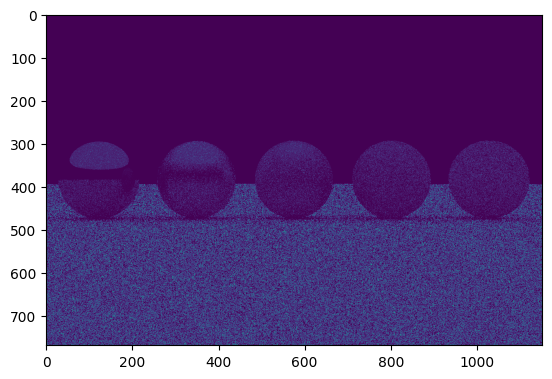

In [253]:
std = results.std(axis=0).mean(-1)

plt.imshow(std/std.max())
plt.show()

In [255]:
spheres = [
    {'pos': [5, -5+l*10, 0], 'radius': 1, 'mat_color': colorsys.hls_to_rgb(l*(1-1/n), 0.5, 1), 'em_color': colorsys.hls_to_rgb(l*(1-1/n), 0.5, 1), 'em_strength': 0, 'mat': max(l, 0.01)}
    for l in jnp.linspace(0, 1, n)
] + [
    #{'pos': [10000+15, 0, 0], 'radius': 10000, 'mat_color': [1, 1, 1], 'em_color': [1, 1, 1], 'em_strength': 0.01, 'mat': 0.5},
    
    # ground
    {'pos': [5, 0, 40000], 'radius': 40000-1, 'mat_color': [1, 1, 1], 'em_color': [1, 1, 1], 'em_strength': 0, 'mat': 1},

    # back wall
    #{'pos': [40000, 0, 0], 'radius': 40000-100, 'mat_color': [0.1, .1, 0.1], 'em_color': [1, 1, 1], 'em_strength': 0, 'mat': 1},

    # ceiling light
    {'pos': [5, 0, -40000], 'radius': 40000-5000, 'mat_color': [1, 1, 1], 'em_color': [1, 1, 1], 'em_strength': 0.000001, 'mat': 1},

    #{'pos': [10, 5, -5], 'radius': 4, 'mat_color': [1, 1, 1], 'em_color': [1, 1, 1], 'em_strength': 0, 'mat': 0},


    #{'pos': [5-math.sin(math.pi*i*2)*10, math.cos(math.pi*i*2)*10, -4], 'radius': 1, 'mat_color': [0, 0, 0], 'em_color': [1, 1, 1], 'em_strength': 3, 'mat': 1},
    #{'pos': [6, -10, 0], 'radius': 0.5, 'mat_color': [0, 0, 0], 'em_color': [0, 0.5, 1], 'em_strength': 40, 'mat': 1},
]
result_img = render_img(spheres)
plt.figure(figsize=(15, 15))
#result_img = result_img.at[:400].set(0)
plt.imshow(result_img/result_img[300:].mean(axis=-1).max(), interpolation='none')
plt.show()

dict_keys(['pos', 'radius', 'mat_color', 'em_color', 'em_strength', 'mat'])


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 10616832 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         4B
              constant allocation:         0B
        maybe_live_out allocation:   10.12MiB
     preallocated temp allocation:         0B
                 total allocation:   10.12MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 10.12MiB
		Operator: op_name="jit(broadcast_in_dim)/jit(main)/broadcast_in_dim[shape=(768, 1152, 3) broadcast_dimensions=()]" source_file="<ipython-input-7-07d4273d6e12>" source_line=16
		XLA Label: broadcast
		Shape: f32[768,1152,3]
		==========================

	Buffer 2:
		Size: 4B
		Entry Parameter Subshape: f32[]
		==========================



In [ ]:
n = 5
spheres = [
    {'pos': [5+math.sin(l*math.pi)*4*1.2, math.cos(l*math.pi)*4, 2], 'radius': 1, 'mat_color': colorsys.hls_to_rgb(l*(1-1/n), 0.5, 0.93), 'em_color': [1, 1, 1], 'em_strength': 0, 'mat': max(l, 0.01)}
    for l in jnp.linspace(0, 1, n)
] + [

    {'pos': [5, 0, 40003], 'radius': 40000, 'mat_color': [0, 0.2, 0.4], 'em_color': [1, 1, 1], 'em_strength': 0.002, 'mat': 1},

    {'pos': [5, 0, -4], 'radius': 1.5, 'mat_color': [0, 0, 0], 'em_color': [1, 1, 1], 'em_strength': 3, 'mat': 1},
    {'pos': [6, -10, 0], 'radius': 0.5, 'mat_color': [0, 0, 0], 'em_color': [0, 0.5, 1], 'em_strength': 40, 'mat': 1},
]

In [ ]:
1

In [ ]:
import time
t = time.time()
dist, hit_point, normal = ray_trace_iter(ray_pos, ray_dirs, sphere_pos, sphere_radius)
print(dist.sum())
print(time.time()-t)

In [ ]:
    {'pos': [10, -5, 2], 'radius': 1, 'mat_color': [1, 0, 0], 'emission_color': [0, 0, 0], 'emission_strength': 0},
    {'pos': [10, -2.5, 2], 'radius': 1, 'mat_color': [1, 1, 0], 'emission_color': [0, 0, 0], 'emission_strength': 0},
    {'pos': [10, 5, 2], 'radius': 1, 'mat_color': [0, 1, 0], 'emission_color': [0, 0, 0], 'emission_strength': 0},
    {'pos': [10, 2.5, 2], 'radius': 1, 'mat_color': [1, 1, 1], 'emission_color': [0, 0, 0], 'emission_strength': 0},
    {'pos': [10, 0, 2], 'radius': 1, 'mat_color': [0, 0, 1], 'emission_color': [0, 0, 0], 'emission_strength': 0},


In [ ]:
"""@jit
def ray_trace_iter(ray_pos, ray_dirs, spheres, sphere_radii):
    closest_hit = jnp.nanargmin(dst, axis=-1)

    # find closest hits
    did_hit_result = jnp.take_along_axis(did_hit, indices=closest_hit[..., None], axis=-1)
    dst_result = jnp.take_along_axis(dst, indices=closest_hit[..., None], axis=-1)
    hit_point_result = jnp.take_along_axis(hit_point, indices=closest_hit[..., None, None], axis=-1).squeeze()
    normal_result = jnp.take_along_axis(normal, indices=closest_hit[..., None, None], axis=-1).squeeze()

    return did_hit_result, dst_result, hit_point_result, normal_result
"""